# Day 4 AM - Inferential Statistics Part 1

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## Resampling

Resampling in statistics means to repeatedly sample values from observed data, with a general goal of assessing random variability in a statistic. To understand what resampling is, let we look at the housing price in Amsterdam data distribution (histogram) below.

In [3]:
house_price = pd.read_csv('https://raw.githubusercontent.com/fahmimnalfrzki/Additional-Materials/main/HousingPrices-Amsterdam-August-2021.csv')
house_price.head()

,Unnamed: 0,Address,Zip,Price,Area,Room,Lon,Lat
0,1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
1,2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
2,3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
3,4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
4,5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538


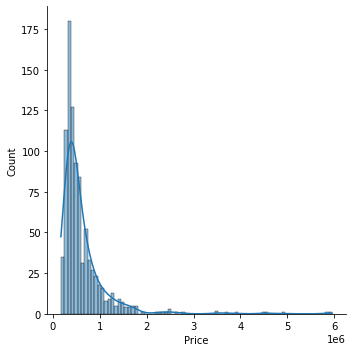

In [4]:
sns.displot(house_price.Price, kde=True, label='Housing Price in Amsterdam')

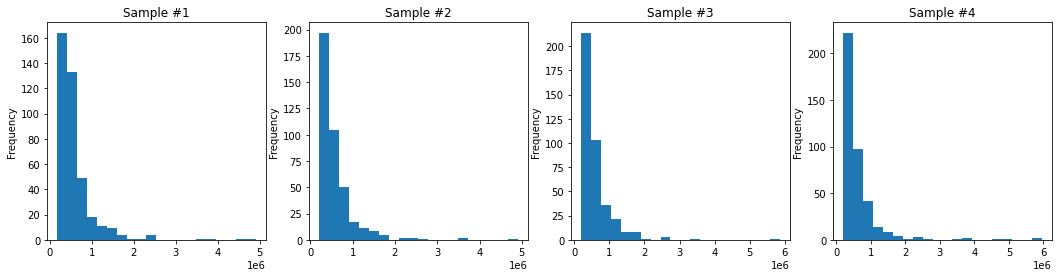

In [5]:
fig,ax = plt.subplots(ncols=4, figsize = (18,4))
for i in range(4):
  house_price.Price.sample(400).plot(kind='hist',bins=20,ax=ax[i])
  ax[i].set_title('Sample #{}'.format(i+1))

We take 100 samples randomly from the housing price data and we did it 4 times. The visualization show that their distribution look the same. It happend simply because of randomness.

## Statistical Significance and P-Value

In [6]:
scanner_data = pd.read_csv('https://raw.githubusercontent.com/fahmimnalfrzki/Additional-Materials/main/scanner_data.csv')
scanner_data

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88
...,...,...,...,...,...,...,...,...
131701,131702,04/07/2016,20203,32900,IEV,FO112,3.0,6.46
131702,131703,04/07/2016,20203,32900,N8U,I36F2,1.0,4.50
131703,131704,04/07/2016,20203,32900,U5F,4X8P4,1.0,5.19
131704,131705,04/07/2016,20203,32900,0H2,ZVTO4,1.0,4.57


In [7]:
category_X52_quantity = scanner_data[scanner_data.SKU_Category == 'X52'].groupby('Date').sum()['Quantity']
category_2ML_quantity = scanner_data[scanner_data.SKU_Category == '2ML'].groupby('Date').sum()['Quantity']

print('Total X52 SKU Category Selling: ',category_X52_quantity.sum(),'items.')
print('Total 2ML SKU Category Selling: ',category_2ML_quantity.sum(),'items.')

print('Daily Average of X52 SKU Category Selling: ',category_X52_quantity.mean(),'items.')
print('Daily Average of 2ML SKU Category Selling: ',category_2ML_quantity.mean(),'items.')

Total X52 SKU Category Selling:  1919.0 items.
Total 2ML SKU Category Selling:  1799.0 items.
Daily Average of X52 SKU Category Selling:  5.390449438202247 items.
Daily Average of 2ML SKU Category Selling:  5.1253561253561255 items.


The daily average of X52 and 2ML SKU category selling are slightly different, around 0.27 difference. In terms of statistics, is the difference significantly different? In other words, whether the difference are real or simply due to chance?

To make sure that the difference are real, we need to check the significance of the populations.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


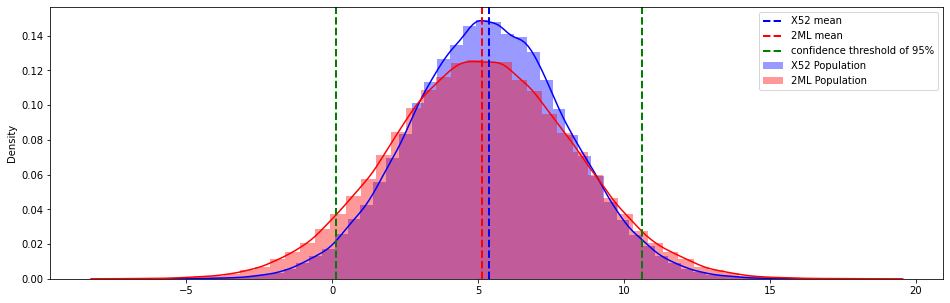

In [14]:
pop_x52 = np.random.normal(category_X52_quantity.mean(),category_X52_quantity.std(),100000)
pop_2ml = np.random.normal(category_2ML_quantity.mean(),category_2ML_quantity.std(),100000)

ci = stats.norm.interval(0.95, pop_x52.mean(), pop_x52.std())
plt.figure(figsize=(16,5))
sns.distplot(pop_x52, label='X52 Population',color='blue')
sns.distplot(pop_2ml, label='2ML Population',color='red')

plt.axvline(pop_x52.mean(), color='blue', linestyle='dashed', linewidth=2, label='X52 mean')
plt.axvline(pop_2ml.mean(), color='red', linestyle='dashed', linewidth=2, label='2ML mean')

plt.axvline(ci[1], color='green', linestyle='dashed', linewidth=2, label='confidence threshold of 95%')
plt.axvline(ci[0], color='green', linestyle='dashed', linewidth=2)
plt.legend()

On the graph above, the green line is the confidence threshold of 95% which related to the p-value of 0.05. We want to check whether our variables are truly different or not. We use X52 data for creating the confidence interval and we use it for reference of our analysis.

The 2ML mean line (the red line) lies in the confidence interval which means the difference is not statistically significant.

## Permutation Test

We have already know based on the visualization above that 2ML and X52 are not significantly different. Furthermore, we can use another tool that is permutation test to measure the p-value so we can take a conclusion that they are not too different.

In [9]:
mean_difference = category_X52_quantity.mean() - category_2ML_quantity.mean()

both_selling = scanner_data[(scanner_data.SKU_Category == 'X52') | (scanner_data.SKU_Category == '2ML')].groupby(['Date','SKU_Category']).sum()['Quantity']
both_selling = both_selling.sample(both_selling.count())

N_X52 = category_X52_quantity.count()
N_2ML = category_2ML_quantity.count()

mean_diffs = []

for i in range(1000): #We do 1000 permutation
    sample_x52 = both_selling.sample(N_X52)
    sample_2ml = both_selling.sample(N_2ML)

    mean_diffs.append(np.abs(sample_x52.mean() - sample_2ml.mean()))

mean_diffs = np.array(mean_diffs)

p_val = 1 - len(np.where(mean_diffs>=mean_difference)[0])/1000

print('P-value:',p_val)



P-value: 0.903


Since the p-value is more than 0.05, so we conclude that both 2ML and X52 are not different significantly.

## T-Test

Student’s t-test or t-test is a parametric inferential statistical method used for comparing the means between two different groups (two-sample t-test) or with the specific value (one-sample t-test).


The t-test can be applied for the extremely small sample size (n = 2 to 5) provided the effect size is large and data follows the t-test assumptions. Remember, a larger sample size is preferred over small sample sizes.
T-test is relatively robust to the assumption of normality and homogeneity of variances when the sample size is large (n ≥ 30).

To understand why t-test when the sample size is large assumed that the distribution is normal and homogen, let we look at the graph below.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


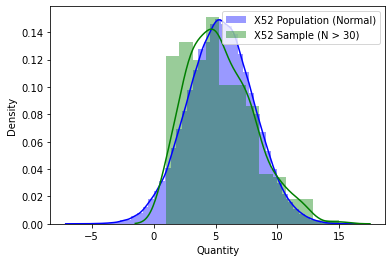

In [10]:
sns.distplot(pop_x52, label='X52 Population (Normal)',color='blue')
sns.distplot(category_X52_quantity, label='X52 Sample (N > 30)',color='green')
plt.legend()

For the large sample of X52 daily sales data, it is clear that the distribution tend to follow the normal distribution and almost homogen just like the population that we generate previously. So, we can use the data for our t-test later on.

There are three kinds of T-test which are:
1. One sample t-test
2. Two sample t-test
3. Paired t-test

Will discuss them later on the AM session. 

Now, we're just focus on that how Python perform the t-test. Let we consider the previous case on permutation test. We calculate the p-value and the result is 0.921 which means that the difference of 2ML dan X52 is not statistically significant. If we test the data using two sample t-test, will the result still shows that their difference is not significant?

In [11]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(category_X52_quantity,category_2ML_quantity)
print('T-statistic:',t_stat)
print('P-value:',p_value)

T-statistic: 1.2087385306883427
P-value: 0.2271685563090583


Our result is quite far from the permutation test one but the conclusion is the same that is the difference between 2ML and X52 average not significant.

## ANOVA

ANOVA is similar to the t-test. It used for testing whether more than two variables are significantly different or not. So, we will test whether the mean of daily sales of IEV,N8U, and U5F are significantly different or not.

In [12]:
IEV_quantity = scanner_data[scanner_data.SKU_Category == 'IEV'].groupby('Date').sum()['Quantity']
N8U_quantity = scanner_data[scanner_data.SKU_Category == 'N8U'].groupby('Date').sum()['Quantity']
U5F_quantity = scanner_data[scanner_data.SKU_Category == 'U5F'].groupby('Date').sum()['Quantity']

print("Daily Average of IEV",IEV_quantity.mean())
print("Daily Average of N8U",N8U_quantity.mean())
print("Daily Average of U5F",U5F_quantity.mean())

Daily Average of IEV 22.915254237288135
Daily Average of N8U 33.46556473829201
Daily Average of U5F 22.610340909090908


It seems that they tend to a conclusion that they are significantly different since N8U average is 33s and the rest is 22s.

In [15]:
f_stat,p_value = stats.f_oneway(IEV_quantity,N8U_quantity,U5F_quantity)
print('P-value:',p_value)

P-value: 6.049412282955515e-36


since the p-value is below 0.05, then we conclude that the difference of IEV, N8U, and U5F is statistically significant.

## Chi-Square Test

Chi-square test is used for testing of independence between two categorical data. Since statistics handling the numerical data, we need to calculate the frequency of each variable and presented by a contingency table.

In [16]:
chi_df=pd.read_csv('https://raw.githubusercontent.com/yug95/MachineLearning/master/Hypothesis%20testing/chi-test.csv')
chi_df

,Gender,Like Shopping?
0,Male,No
1,Female,Yes
2,Male,Yes
3,Female,Yes
4,Female,Yes
5,Male,Yes
6,Male,No
7,Female,No
8,Female,No


In [17]:
contingency_table=pd.crosstab(chi_df["Gender"],chi_df["Like Shopping?"])
contingency_table

Like Shopping?,No,Yes
Gender,,
Female,2,3
Male,2,2


In [18]:
stat, p, dof, expected = stats.chi2_contingency(contingency_table)
print('p=%.3f' % (p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

p=0.708
Probably independent
